# Steinschlag Challenge HS21

## Mitglieder
- Julia Lobatón
- Lukasz Gothszalk
- Patrick Schürmann
- Thomas Mandelz

## Einführung

Nachfolgend unsere Abgabe zur Steinschlag Challenge DS HS 2021.

## Die Aufgabestellung

Die Kantonsstrasse unterhalb Schiers (GR) ist vom Steinschlag betroffen. Steine lösen sich von zwei unterschiedlichen Stellen an der Felswand ab (Ablösungszone 1 und Ablösungszone 2). Der betroffene Strassenabschnitt ist mit Steinfangnetzen gesichert, die jedoch in die Jahre gekommen sind und die angestrebte Sicherheit nicht mehr gewährleisten können. Die Planung für Ersatznetze hat bereits begonnen, kann aber frühstens in einem Jahr umgesetzt werden.

In den letzten Monaten haben sich mehrere Steinschlagereignisse ereignet. Kommt es im Lauf des nächsten Jahres zu weiteren vergleichbaren Ereignissen, könnten die alten Sicherheitsnetze versagen und die Verkehrsteilnehmer einem grossen Sicherheitsrisiko ausgesetzt sein. Die Bevölkerung ist verunsichert und der Kantonsingenieur muss schnell entscheiden, ob das Risiko für die Verkehrsteilnehmer zu gross ist und die Kantonsstrasse vorübergehend gesperrt werden muss. Der Kantonsingenieur hat sie beauftragt, anhand von vorhanden Daten die Wahrscheinlichkeit eines Todesfalls zu berechnen und eine Empfehlung bezüglich der Schliessung bzw Offenhaltung der Strasse auszusprechen.

Damit die Strasse offen bleiben kann, muss gezeigt werden, dass die jährliche Wahrscheinlichkeit von Todesfällen infolge Steinschlags kleiner als 10-4 ist.

Für die Planung der neuen Sicherheitsnetze, hat ein beauftragter Geologe, über drei Monate Daten zu den Steinschlagereignisse aufgenommen. Dabei wurde Steingeschwindigkeit, Steinmasse und Zeitpunkt und der Zeitpunkt des Ereignis registriert. 

Ein beauftragtes Ingenieurbüro hat geschätzt, dass die Sicherheitsnetze bis zu einer Aufprallenergie von 1000 kJ sicher sind. Falls bereits ein Stein mit über 2000kg in den Sicherheitsnetzen liegt, beträgt die Aufprallenergie, die von den Sicherheitsnetzen aufgenommen werden kann, nur noch 500 kJ. Steine in den Sicherheitsnetze werden vom Unterhaltsteam entfernt (die Reaktionszeit beträgt 24 Stunden). 

Das tägliche Verkehrsaufkommen beträgt 1200 Autos. Stau kommt auf der Strecke nicht vor. Die Tempolimite beträgt 60 km/h. 

## Vorbereitung und Funktionsdefinition

Zur Lösung der Challange haben wir zuerst die notwendigen Python Libraries importiert und Variabeln definiert.

In [1]:
# Import Bibliotheken
from scipy import stats
from statistics import mean
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from numpy.random import default_rng

# Globale Variablen
# Anzahl Durchgänge in der Monte Carlo Simulation
sizeMonteCarloSim = 50_000_000
sizeMonteCarloSimZone1 = int(sizeMonteCarloSim * 0.68)
sizeMonteCarloSimZone2 = int(sizeMonteCarloSim * 0.32)

# Grenzwert der Wahrscheinlichkeit
ProbabilityLimit = 10 ** -4


# Pandas Warnungen ausblenden für Ketten Aufrufe
pd.options.mode.chained_assignment = None  # default='warn'




In einem ersten Schritt haben wir das Fitting zur Bestimmung der Verteilungen (Masse, Geschwindigkeit Zeitabstände zwischen Steinschlägen) vorbereitet und die Daten dafür importiert und aufbereitet.

In [2]:
# Funktion welche eine Verteilungart fitten kann
def FindmostfittingDistribution(ColumnName,MatrixColumn):

    # Unterdrückt Division durch 0 Warnungen
    with np.errstate(divide='ignore',invalid='ignore'):
        # Liste von Verteilungen welche gefittet werden können
        list_of_dists = ['cauchy','expon', 'logistic', 'norm','uniform','gamma']
    
        results = []
        # Kolmogorov-Smirnov Test für jede Verteilung um den Typ zu finden
        for i in list_of_dists:
            dist = getattr(stats, i)
            param = dist.fit(MatrixColumn)
            a = stats.kstest(MatrixColumn, i, args=param)
            results.append((i, a[0], a[1]))

        # sortieren der Resultate nach Höchstem PWert
        results.sort(key=lambda x: float(x[2]), reverse=True)
        # Plotten von Verteilung
        MatrixColumn.hist()
        plt.title(f"Histogram der Spalte: {ColumnName}")
        plt.xlabel(f"{ColumnName}")
        plt.ylabel("Dichte")
        plt.show()
        
        # Ausgabe der Resultate
        print(f"Die folgenden Verteilungen der Spalte {ColumnName} wurden geprüft und fitten am besten in absteigender Reihenfolge:")
        for j in results:
            print("{}: pvalue={}".format(j[0], j[1], j[2]))
        
        

# Funktion um die CSV's zu lesen
def ReadDataframe():
    # Lesen der ersten CSV Datei
    dataFile1 = pd.read_csv("out_1.csv")
    # Lesen der zweiten CSV Datei
    dataFile2 = pd.read_csv("out_2.csv")

    # Zonen werden als Spalte ergänzt
    dataFile1['zone']='1'
    dataFile2['zone']='2'

    # Zusammenführen der beiden Zonen Datenframes
    mergedDataFile = dataFile1.append(dataFile2)
    return mergedDataFile
    
# Funktion zur Berechnung eines Zeitunterschieds und Ergänzung der jeder Stunde im Datenframe als Row
def CalculateTimeDeltaHours(mergedDataFile):
    # Stunde dazwischen als Rows ergänzen
    TimebeforeStoneZone1 = mergedDataFile.loc[mergedDataFile["zone"] == "1","DateTime"].diff()
    TimebeforeStoneZone2 = mergedDataFile.loc[mergedDataFile["zone"] == "2","DateTime"].diff()
    
    # Zeitdelta ergänzen
    mergedDataFile.loc[mergedDataFile["zone"] == "1","TimebeforeStone"] = TimebeforeStoneZone1.astype('timedelta64[h]').fillna(0)     
    mergedDataFile.loc[mergedDataFile["zone"] == "2","TimebeforeStone"] = TimebeforeStoneZone2.astype('timedelta64[h]').fillna(0)     
    return mergedDataFile


# Bereinigungen und Berechnungen der Datenframes
def CalculateandUpdateColumns(mergedDataFile):
    
    #Energie mittels der Formel (KE=1/2mv^2)/1000 in m = kg und v = m/s -> Kj
    mergedDataFile['energy']=((mergedDataFile['mass']/2)*(mergedDataFile['velocity']**2) / 1000)

    # Auslöser Spalte ergänzen wenn ein Stein gefallen ist
    mergedDataFile["Trigger"] = np.where(mergedDataFile["zone"] == 0, 0, 1) 

    # Umformatierung zum Datums Datentyp
    mergedDataFile["DateTime"] = pd.to_datetime(mergedDataFile['date'] + ' ' + mergedDataFile['timestamp'])

    # Nach Datum ordnen
    mergedDataFile = mergedDataFile.sort_values(by=['DateTime'])
    mergedDataFile = mergedDataFile.reset_index(drop=True)
    # Verschieben der Steine um eine Stunde welche zur gleichen Stunde fallen
    mergedDataFile.loc[1, 'timestamp'] = "10:00"
    mergedDataFile.loc[44, 'timestamp'] = "13:00"
    mergedDataFile.loc[89, 'timestamp'] = "13:00"

    # Update der Datumsspalte
    mergedDataFile["DateTime"] = pd.to_datetime(mergedDataFile['date'] + ' ' + mergedDataFile['timestamp'])
    return mergedDataFile

# Funktion zur Erstellung der Timeserie für die Plots
def TimeSeriePlots(mergedDataFile):
        # Leere Stunden ergänzen
        dfTimeSerie = mergedDataFile
        dfTimeSerie = dfTimeSerie.set_index(mergedDataFile["DateTime"])
        dfTimeSerie = dfTimeSerie.resample('H').first().fillna(0)
        dfTimeSerie['DateTime'] = dfTimeSerie.index

        # Fehlende Tage und Stunden ergänzen
        dfTimeSerie["date"] = dfTimeSerie["DateTime"].dt.date
        dfTimeSerie["timestamp"] = dfTimeSerie["DateTime"].dt.time
        
        # berechnen der rollierenden Energie sowie masse über 24 Stunden
        dfTimeSerie["rollingEnergy24h"] = dfTimeSerie["energy"].rolling(24, min_periods=1).sum()
        dfTimeSerie["rollingmass24h"] = dfTimeSerie["mass"].rolling(24, min_periods=1).sum()


        # Berechnung ob Durchbrüche beobachtet wurden mittels Durchbruchkriterien
        dfTimeSerie["BreachEnergy"] = np.where(dfTimeSerie["energy"] >= 1000, 1, 0)
        dfTimeSerie["BreachFullNet"] = np.where((dfTimeSerie["energy"] >= 500) & (dfTimeSerie["rollingmass24h"] >= 2000), 1, 0)
        return dfTimeSerie   

## Aufbereitung der Daten

In [3]:
# Initieren von Datenframe
listfeatures_samples = pd.DataFrame()
# Lesen des CSV's
mergedDataFile = ReadDataframe()
# Bereinigungen und Berechnungen der Datenframes ausführen
mergedDataFile = CalculateandUpdateColumns(mergedDataFile)
# Berechnen der Zeitunterschiede
mergedDataFile = CalculateTimeDeltaHours(mergedDataFile)
# Bereinigungen und Berechnungen der Datenframes für Plots ausführen
dfTimeSerie = TimeSeriePlots(mergedDataFile)

# Splitten in Zone 1 und Zone 2
dataFile1 = mergedDataFile.loc[mergedDataFile['zone'] == "1"]
dataFile2 = mergedDataFile.loc[mergedDataFile['zone'] == "2"]

## Verteilungsfitting 

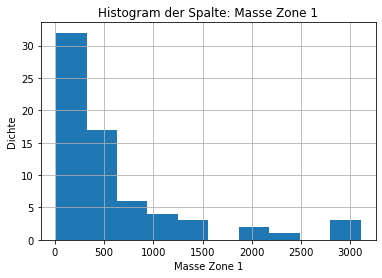

Die folgenden Verteilungen der Spalte Masse Zone 1 wurden geprüft und fitten am besten in absteigender Reihenfolge:
expon: pvalue=0.11243165125691623
gamma: pvalue=0.11760617507322291
cauchy: pvalue=0.1801401376182128
logistic: pvalue=0.18169255347020843
norm: pvalue=0.2414309639409059
uniform: pvalue=0.5275093219694087


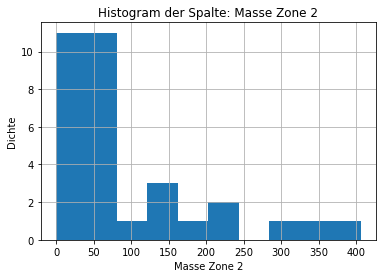

Die folgenden Verteilungen der Spalte Masse Zone 2 wurden geprüft und fitten am besten in absteigender Reihenfolge:
expon: pvalue=0.14782678488159295
cauchy: pvalue=0.18430641176211526
logistic: pvalue=0.2007862539643812
gamma: pvalue=0.2186223695992287
norm: pvalue=0.2734792372426059
uniform: pvalue=0.4978448275862069


In [4]:
# Fitten und Plotten von Massen Verteilungen
FindmostfittingDistribution("Masse Zone 1",dataFile1["mass"])
FindmostfittingDistribution("Masse Zone 2",dataFile2["mass"])

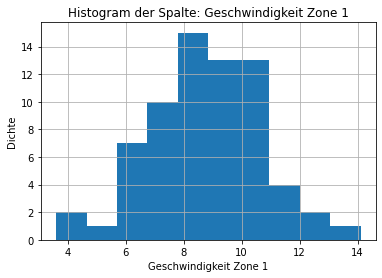

Die folgenden Verteilungen der Spalte Geschwindigkeit Zone 1 wurden geprüft und fitten am besten in absteigender Reihenfolge:
norm: pvalue=0.05935470523940989
logistic: pvalue=0.05996742225913976
gamma: pvalue=0.06380655088791254
cauchy: pvalue=0.08213316837233586
uniform: pvalue=0.20266106442577037
expon: pvalue=0.3321926521972434


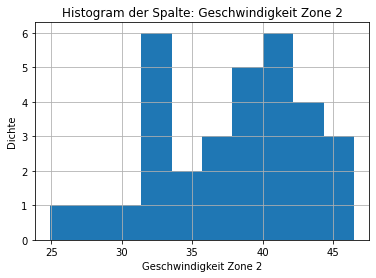

Die folgenden Verteilungen der Spalte Geschwindigkeit Zone 2 wurden geprüft und fitten am besten in absteigender Reihenfolge:
norm: pvalue=0.10464125364475385
gamma: pvalue=0.11342375284786921
logistic: pvalue=0.11663594484492207
cauchy: pvalue=0.14261401090149683
uniform: pvalue=0.22106481481481483
expon: pvalue=0.3161806174860554


In [5]:
# Fitten und Plotten von Geschwindigkeits Verteilungen
FindmostfittingDistribution("Geschwindigkeit Zone 1",dataFile1["velocity"])
FindmostfittingDistribution("Geschwindigkeit Zone 2",dataFile2["velocity"])

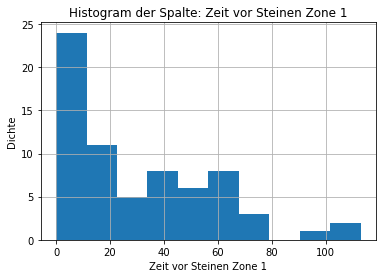

Die folgenden Verteilungen der Spalte Zeit vor Steinen Zone 1 wurden geprüft und fitten am besten in absteigender Reihenfolge:
expon: pvalue=0.11605109133166369
norm: pvalue=0.13728449484558025
gamma: pvalue=0.13949129784027292
logistic: pvalue=0.15100739323840795
cauchy: pvalue=0.23167911493976678
uniform: pvalue=0.35163977095262877


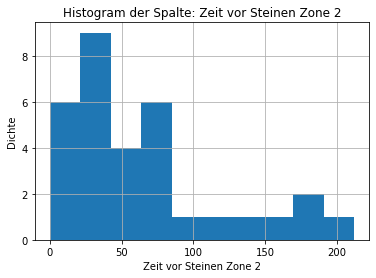

Die folgenden Verteilungen der Spalte Zeit vor Steinen Zone 2 wurden geprüft und fitten am besten in absteigender Reihenfolge:
gamma: pvalue=0.07967496966622939
expon: pvalue=0.12449087491280508
logistic: pvalue=0.12893665228294315
norm: pvalue=0.16468953585356227
cauchy: pvalue=0.175119749970919
uniform: pvalue=0.39917452830188677


In [6]:
# Fitten und Plotten der zeitlichen Ablösungen 
FindmostfittingDistribution("Zeit vor Steinen Zone 1",dataFile1["TimebeforeStone"])
FindmostfittingDistribution("Zeit vor Steinen Zone 2",dataFile2["TimebeforeStone"])

### Eigenschaftsübersicht der Beobachtungen
In der Zone 1 wurden 68 Steine beobachtet und in der Zone 2 waren es 32 Beobachtungen.

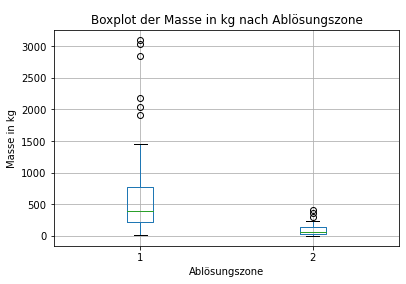

In [7]:
# Boxplot der Massen pro Zone
mergedDataFile.boxplot(column="mass", by="zone")
plt.title("Boxplot der Masse in kg nach Ablösungszone")
plt.suptitle(" ")
plt.xlabel("Ablösungszone")
plt.ylabel("Masse in kg")
plt.show()

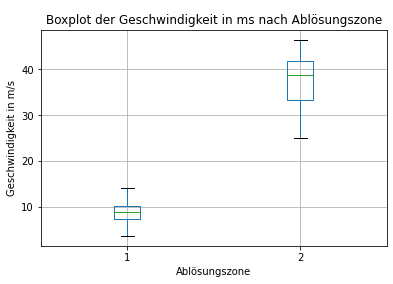

In [8]:
# Boxplot der Geschwindigkeiten pro Zone
mergedDataFile.boxplot(column="velocity", by="zone")
plt.title("Boxplot der Geschwindigkeit in ms nach Ablösungszone")
plt.suptitle(" ")
plt.xlabel("Ablösungszone")
plt.ylabel("Geschwindigkeit in m/s")
plt.show()

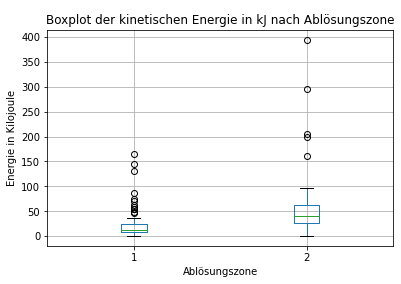

In [9]:
# Boxplot der Energie pro Zone
mergedDataFile.boxplot(column="energy", by="zone")
plt.title("Boxplot der kinetischen Energie in kJ nach Ablösungszone")
plt.suptitle(" ")
plt.xlabel("Ablösungszone")
plt.ylabel("Energie in Kilojoule")
plt.show()

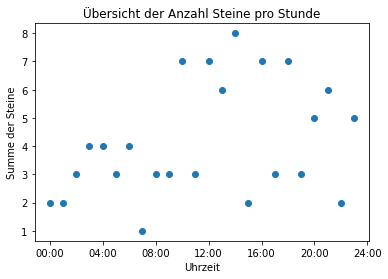

In [10]:
# Scatterplot der gefallenen Steine pro Stunde an einem Tag (0h-24h)
ScatterplotTime = mergedDataFile.groupby(['timestamp']).agg({'Trigger': 'sum'})
plt.scatter(ScatterplotTime.index, ScatterplotTime['Trigger'])
plt.xticks(["00:00", "04:00", "08:00", "12:00", "16:00", "20:00", "24:00"])
plt.title("Übersicht der Anzahl Steine pro Stunde")
plt.xlabel("Uhrzeit")
plt.ylabel("Summe der Steine")
plt.show()

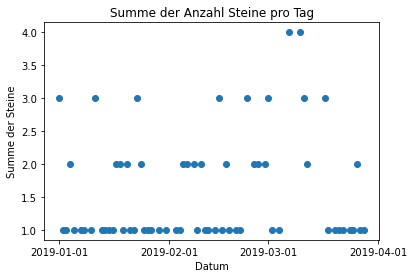

In [11]:
# Scatterplot der gefallenen Steine pro Tag (01.01.2019 - 01.04.2019)
ScatterplotDate = mergedDataFile.groupby(mergedDataFile['DateTime'].dt.date).agg({'Trigger': 'sum'})
plt.scatter(ScatterplotDate.index, ScatterplotDate['Trigger'])
plt.xticks(["2019-01-01 00:00:00", "2019-02-01 00:00:00","2019-03-01 00:00:00", "2019-04-01 00:00:00"])
plt.title("Summe der Anzahl Steine pro Tag")
plt.xlabel("Datum")
plt.ylabel("Summe der Steine")
plt.show()

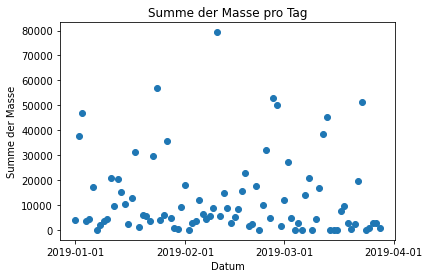

In [12]:
# Scatterplot der Summe der Masse pro Tag (01.01.2019 - 01.04.2019)
ScatterplotMass = dfTimeSerie.groupby(dfTimeSerie['DateTime'].dt.date).agg({'rollingmass24h': 'sum'})
plt.scatter(ScatterplotMass.index, ScatterplotMass['rollingmass24h'])
plt.xticks(["2019-01-01 00:00:00", "2019-02-01 00:00:00","2019-03-01 00:00:00", "2019-04-01 00:00:00"])
plt.title("Summe der Masse pro Tag")
plt.xlabel("Datum")
plt.ylabel("Summe der Masse")
plt.show()

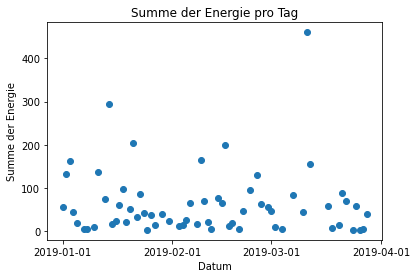

In [13]:
# Scatterplot der Summe der Energie pro Tag (01.01.2019 - 01.04.2019)
ScatterplotEnergy = mergedDataFile.groupby(mergedDataFile["DateTime"].dt.date).agg({'energy': 'sum'})
plt.scatter(ScatterplotEnergy.index, ScatterplotEnergy['energy'])
plt.xticks(["2019-01-01 00:00:00", "2019-02-01 00:00:00","2019-03-01 00:00:00", "2019-04-01 00:00:00"])
plt.title("Summe der Energie pro Tag")
plt.xlabel("Datum")
plt.ylabel("Summe der Energie")
plt.show()

Nachdem die Grundlage geschaffen wurde, haben wir die Monte Carlo Simulationen für beide Zonen durchgeführt.

In [14]:
# Definition der Verteilungsinformationen für die Zonen aus dem vorherigen Fitting
listfeatures_distributions_zone1 = [["mass", "exponential"], ["velocity", "normal"], ["TimebeforeStone", "exponential"]]
listfeatures_distributions_zone2 = [["mass", "exponential"], ["velocity", "normal"], ["TimebeforeStone", "gamma"]]

# Mainloop for Monte Carlo Sim
# Zone 1
listfeatures_samples_zone_1 = pd.DataFrame()
zoneindex = 0

for featureDistribution in listfeatures_distributions_zone1:
    zoneindex = 1
    if (featureDistribution[1] == "exponential"):
        # Verteilungsparameter bestimmen
        meanExponential1 = mean(dataFile1[featureDistribution[0]])
        # Generieren von samples die exponential verteilt sind
        rng = default_rng()
        sample = rng.exponential(meanExponential1,size=sizeMonteCarloSimZone1)
        # Generierte Werte ins Datenframe hinzufügen
        listfeatures_samples_zone_1[featureDistribution[0]] = sample

    elif(featureDistribution[1] == "normal"):
        # Verteilungsparameter bestimmen
        meanNormal1 = mean(dataFile1[featureDistribution[0]])
        stdNormal1 = np.std(dataFile1[featureDistribution[0]])
        # Generieren von samples die normal verteilt sind
        rng = default_rng()
        sample = rng.normal(meanNormal1, stdNormal1,size=sizeMonteCarloSimZone1)
        # Generierte Werte ins Datenframe hinzufügen
        listfeatures_samples_zone_1[featureDistribution[0]] = sample

    elif(featureDistribution[1] == "gamma"):
        # Verteilungsparameter bestimmen
        meanGamma1 = mean(dataFile1[featureDistribution[0]])
        # Generieren von samples die gamma verteilt sind
        rng = default_rng()
        sample = rng.gamma(meanGamma1, size=sizeMonteCarloSimZone1)
        # Generierte Werte ins Datenframe hinzufügen
        listfeatures_samples_zone_1[featureDistribution[0]] = sample

# Zone 2
listfeatures_samples_zone_2 = pd.DataFrame()
zoneindex = 0

for featureDistribution in listfeatures_distributions_zone2:
    zoneindex = 2
    if (featureDistribution[1] == "exponential"):
        # Verteilungsparameter bestimmen
        meanExponential2 = mean(dataFile2[featureDistribution[0]])
        # Generieren von samples die exponential verteilt sind
        rng = default_rng()
        sample = rng.exponential(meanExponential2, size=sizeMonteCarloSimZone2)
        # Generierte Werte ins Datenframe hinzufügen
        listfeatures_samples_zone_2[featureDistribution[0]] = sample

    elif(featureDistribution[1] == "normal"):
        # Verteilungsparameter bestimmen
        meanNormal2 = mean(dataFile2[featureDistribution[0]])
        stdNormal2 = np.std(dataFile2[featureDistribution[0]])
        # Generieren von samples die normal verteilt sind
        rng = default_rng()
        sample = rng.normal(meanNormal2, stdNormal2,size=sizeMonteCarloSimZone2)
        # Generierte Werte ins Datenframe hinzufügen
        listfeatures_samples_zone_2[featureDistribution[0]] = sample

    elif(featureDistribution[1] == "gamma"):
        # Verteilungsparameter bestimmen
        meanGamma2 = mean(dataFile2[featureDistribution[0]])
        # Generieren von samples die gamma verteilt sind
        rng = default_rng()
        sample = rng.gamma(meanGamma2, size=sizeMonteCarloSimZone2)
        # Generierte Werte ins Datenframe hinzufügen
        listfeatures_samples_zone_2[featureDistribution[0]] = sample


Nach der Simulation der Daten, wurden diese zusammengeführt, verarbeitet und die Anzahl Netzdurchschläge berechnet.

In [15]:
# Berechnung der Energie der simulierten Steinschläge pro Zone
listfeatures_samples_zone_1['energy'] = ((listfeatures_samples_zone_1['mass']/2)*(listfeatures_samples_zone_1['velocity']**2) / 1000)
listfeatures_samples_zone_2['energy'] = ((listfeatures_samples_zone_2['mass']/2)*(listfeatures_samples_zone_2['velocity']**2) / 1000)

# Markierung der Steine, die mit der Energie das Netz durchschlagen haben
listfeatures_samples_zone_1['direct_breakthrough'] = np.where((listfeatures_samples_zone_1["energy"] >= 1000), 1, 0)
listfeatures_samples_zone_2['direct_breakthrough'] = np.where((listfeatures_samples_zone_2["energy"] >= 1000), 1, 0)

# Hinzufügen der Zone als Spalte
listfeatures_samples_zone_1['Zone'] = 1
listfeatures_samples_zone_2['Zone'] = 2

# Kumulierte Summe der Zeitdifferenzen berechnen 
listfeatures_samples_zone_1["CumsumHoursbeforeStone"] = listfeatures_samples_zone_1["TimebeforeStone"].cumsum()
listfeatures_samples_zone_2["CumsumHoursbeforeStone"] = listfeatures_samples_zone_2["TimebeforeStone"].cumsum()

# Kombinieren beider Sample Datenframes
listfeatures_samples = listfeatures_samples_zone_1.append(listfeatures_samples_zone_2, ignore_index=True)

# Sortieren und Index neu setzen
listfeatures_samples = listfeatures_samples.sort_values(by='CumsumHoursbeforeStone')
listfeatures_samples = listfeatures_samples.reset_index(drop=True)

# Definition des Jahres in welcher der Stein gefallen ist (365d * 24h)
listfeatures_samples["Year"] = listfeatures_samples['CumsumHoursbeforeStone'].floordiv(8760)


# Berechnet, wieviel Masse pro Tag im Netz ist
listfeatures_samples["Tag"] = listfeatures_samples['CumsumHoursbeforeStone'] // 24
Netzvoll = listfeatures_samples.groupby("Tag")["mass"].agg("sum")
Netzvoll = pd.DataFrame({'Tag': Netzvoll.index, 'Tagesmasse': Netzvoll.values})
listfeatures_samples = listfeatures_samples.merge(Netzvoll, how="left", on="Tag")
listfeatures_samples["PossibleBreachFullNet"] = np.where((listfeatures_samples["energy"] >= 500) & (listfeatures_samples["Tagesmasse"] >= 2000), 1, 0)


CountBreachFullNet = 0
ListPossibleBrechFullNet = listfeatures_samples[listfeatures_samples["PossibleBreachFullNet"] == 1]
ListPossibleBrechFullNet = ListPossibleBrechFullNet.reset_index()
for i in range(len(ListPossibleBrechFullNet)):
    Day = ListPossibleBrechFullNet.loc[i, "Tag"]
    ToCheck = listfeatures_samples[listfeatures_samples["Tag"] == Day]
    ToCheck = ToCheck.reset_index()
    ToCheck["CumsumMass"] = ToCheck["mass"].shift().cumsum()
    for i in range(len(ToCheck)):
        if ToCheck.loc[i, "direct_breakthrough"] == 1:
            break  # break weil wenn das Netz durchbrochen ist, die Strasse gesperrt wird
        else:
            if (ToCheck.loc[i, "energy"] >= 500) & (ToCheck.loc[i, "CumsumMass"] >= 2000):
                CountBreachFullNet += 1
                break

# Ausgabe der Simulationensresultate
print("Anzahl simulierter Jahre:", listfeatures_samples["Year"].max())
print("Anzahl Durchbrüche nach vollem Netz:", CountBreachFullNet)
print("Anzahl direkter Durchbrüche:",listfeatures_samples["direct_breakthrough"].sum())


Anzahl simulierter Jahre: 117297.0
Anzahl Durchbrüche nach vollem Netz: 936
Anzahl direkter Durchbrüche: 327


## Netzdurchbruch Wahrscheinlichkeit pro Jahr

In [16]:
# Alle Durchbrüche berechnen
AllBreaches = float(CountBreachFullNet + listfeatures_samples["direct_breakthrough"].sum())
# Alle simulierten Jahre
MaxYears = float(listfeatures_samples["Year"].max())

# Wahrscheinlichkeit von einem Durchbruch pro Jahr
ProbabilityNetBreach = AllBreaches / MaxYears
print('{0:.10f}'.format(ProbabilityNetBreach))

0.0107675388


## Auto Wahrscheinlichkeit pro Stunde

In diesem Schritt wurde die Anzahl Durchfahrten pro Stunde berechnet.

In [17]:
# Autos pro Stunde
ProbabilityCar = 1200/24
print('{0:.10f}'.format(ProbabilityCar))

50.0000000000


## Wahrscheinlichkeit Autoaufprall
Der Bremsweg einer Gefahrenbremsung eines Fahrzeugs ist berechenbar durch die Formel ((Geschwindigkeit in km/h : 10) x (Geschwindigkeit in km/h : 10) / 2 ) <cite id="y2hoh">(Gebhardt, 2018)</cite>.

In [18]:
# Geschwindigkeit eines Autos in m/s
VelocityCarMs = 60 / 3.6
# Geschwindigkeit eines Autos in m/s
VelocityCar = 60
# Bremsweg definieren (Vollbremse = Bremsweg/2)
BrakeWay = (VelocityCar / 10) * (VelocityCar / 10) / 2
# Autolänge definieren
AutoLength = 4.4

# Gefahrenzone für ein Auto welches durchfährt
DangerZone = BrakeWay + AutoLength


# Wahrscheinlichkeit für ein Auto in der Gefahrenzone zu sein pro Tag
ProbabilityCarImpact = (DangerZone / VelocityCarMs) / (60*60)
print('{0:.10f}'.format(ProbabilityCarImpact))

0.0003733333


## Todesfall Wahrscheinlichkeit bei Aufprall
Nach dem Bericht der Eidgenössischen Forschungsanstalt für Wald, Schnee und Landschaft <cite id="iyuia">(Gerber, 2019)</cite> verunfallen 4/14 Personen tödlich auf Hauptstrassen im Zusammenhang mit einem Steinschlag.


In [19]:
# Wahrscheinlichkeit das ein Verunfallter stirbt
ProbabilityDeath = float(4/14)
print('{0:.10f}'.format(ProbabilityDeath))

0.2857142857


## Durchschnittspassagiere

Die Durchschnittspassagiere pro Fahrzeug wurden durch verschiedene Ämter in Graubünden <cite id="epsn8">(Hartmann &#38; Walter, 2018)</cite>  in einem Zensus im Jahr 2018 als 1.66 erhoben.




In [20]:
# Durschnittspassagiere pro Fahrzeug
MeanPassengers = float(1.66)
print('{0:.10f}'.format(MeanPassengers))

1.6600000000


Zuletzt haben wir die errechneten Wahrscheinlichkeiten verknüpft und mit den Vorgaben zur Strassensicherheit verglichen. Daraus abgeleitet wird die Empfehlung erstellt.

In [21]:
#Berechnung Wahrscheinlichkeit für Todesfälle
ProbabilityDeathCase = ProbabilityNetBreach  * ProbabilityCar * ProbabilityCarImpact * ProbabilityDeath * MeanPassengers

print("Errechnete Wahrscheinlichkeit für einen Todesfall:", '{0:.10f}'.format(ProbabilityDeathCase))
print("Zugelassene Wahrscheinlichkeit:", '{0:.10f}'.format(ProbabilityLimit))

# Ausgabe der Entscheidung
if AllBreaches == 0:
    print("Keine Durchbrüche vorhanden. Die Simulationanzahl muss erhöht werden.")

if ProbabilityDeathCase >= ProbabilityLimit :
    print(f"Wahrscheinlichkeitsgrenzwert {ProbabilityLimit} überschritten.")
    
else:
    print(f"Wahrscheinlichkeitsgrenzwert {ProbabilityLimit} nicht überschritten. Die Strasse kann offen bleiben!")
        

Errechnete Wahrscheinlichkeit für einen Todesfall: 0.0000953286
Zugelassene Wahrscheinlichkeit: 0.0001000000
Wahrscheinlichkeitsgrenzwert 0.0001 nicht überschritten. Die Strasse kann offen bleiben!


## Mehrfache Ausführung der Simulation
Um aufzuzeigen das der Randomness Faktor nicht zu gross ist kann die Simulation mehrfach ausgeführt werden.

In [22]:
import CheckDeviation as cd

Iterations = 5
SimSize = 50_000_000

cd.Check(Iterations,SimSize)



0.0000924628
0.0001000000
Wahrscheinlichkeitsgrenzwert 0.0001 nicht überschritten. Die Strasse kann offen bleiben!
0.0000966971
0.0001000000
Wahrscheinlichkeitsgrenzwert 0.0001 nicht überschritten. Die Strasse kann offen bleiben!
0.0000963894
0.0001000000
Wahrscheinlichkeitsgrenzwert 0.0001 nicht überschritten. Die Strasse kann offen bleiben!
0.0000967619
0.0001000000
Wahrscheinlichkeitsgrenzwert 0.0001 nicht überschritten. Die Strasse kann offen bleiben!
0.0000934448
0.0001000000
Wahrscheinlichkeitsgrenzwert 0.0001 nicht überschritten. Die Strasse kann offen bleiben!
['0.0000924628', '0.0000966971', '0.0000963894', '0.0000967619', '0.0000934448']


## Quellenverzeichnis

<!-- BIBLIOGRAPHY START -->
<div class="csl-bib-body">
  <div class="csl-entry">Gebhardt, M. (2018, April 24). <i>Bremsweg-Formel: So geht die Berechnung!</i> autobild.de. https://www.autobild.de/artikel/bremsweg-formel-13443369.html#anchor_1</div>

  <div class="csl-entry">Gerber, W. (2019). <i>Naturgefahr_Steinschlag</i>. PDF Download. https://www.gr.ch/DE/Medien/Mitteilungen/MMStaka/2018/MedienDokumente/Bericht_Mikrozensus_2015_ohneAnhang.pdf</div>

  <div class="csl-entry">Hartmann, P., &#38; Walter, P. (2018, January 4). <i>Mikrozensus Graubünden</i>. PDF Download. https://www.gr.ch/DE/Medien/Mitteilungen/MMStaka/2018/MedienDokumente/Bericht_Mikrozensus_2015_ohneAnhang.pdf</div>

</div>
<!-- BIBLIOGRAPHY END -->